# Make Plots of Trajectories
Optimizing the trajecotries is expensive, so I've created a separate notebook for making useful plots

In [45]:
%matplotlib inline
from matplotlib import pyplot as plt
import pickle as pkl
import pandas as pd
import numpy as np
import gzip
import json
import os

## Load in Data
Get things we'd need to make plots

In [5]:
random_data = pd.read_pickle(os.path.join('..', 'data', 'random_data.pkl.gz'))

In [6]:
channel_data = pd.read_pickle(os.path.join('..', 'data', 'channel_data.pkl.gz'))

In [10]:
with open('traj_optimizer.pkl.gz', 'rb') as fp:
    trajopt = pkl.load(gzip.open(fp))

In [11]:
with open('optimized_trajecotries.json') as fp:
    optimized_trajs = json.load(fp)

In [41]:
with open('sampling-rates.json') as fp:
    sampling_rates = json.load(fp)

## Plot the trajectories
We want to compute the channel, random, and optimized trajectory

Make the optimized trajectory

In [30]:
optimized_data = trajopt.generate_trajectory(optimized_trajs['single'][:3], optimized_trajs['single'][3:],
                                            1, random_data['displacement'].max(), len(random_data))

Get the sampling scores

In [35]:
%%time
scores = {
    'Random': trajopt.score_sampling_performance(random_data),
    'Channel': trajopt.score_sampling_performance(channel_data),
    'Optimized': trajopt.score_sampling_performance(optimized_data)
}

CPU times: user 13.4 s, sys: 4.05 s, total: 17.4 s
Wall time: 17.6 s


Get the sampling points

In [19]:
sampling_proj = trajopt.neighbors._fit_X

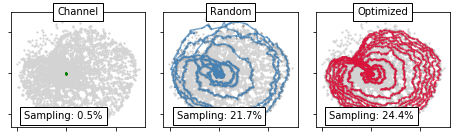

In [40]:
fig, axs = plt.subplots(1, 3)

hit_ms = 1.5

# Get the points the random trajectory passes near
# Make the backgrounds
for ax in axs:
    ax.scatter(sampling_proj[:, 0], sampling_proj[:, 1], c='lightgray', s=hit_ms)
    
# Plot the channel trajectory
hits = trajopt.get_near_points(channel_data)
channel_proj = trajopt.manifold.transform(channel_data[trajopt.X_cols])
axs[0].scatter(sampling_proj[hits, 0], sampling_proj[hits, 1], s=hit_ms,
              c='darkgrey')
axs[0].plot(channel_proj[:, 0], channel_proj[:, 1], '.-', ms=0.8, alpha=0.7, color='green')

    
# Plot the random trajectory
hits = trajopt.get_near_points(random_data)
random_proj = trajopt.manifold.transform(random_data[trajopt.X_cols])
axs[1].scatter(sampling_proj[hits, 0], sampling_proj[hits, 1], s=hit_ms,
              c='darkgrey')
axs[1].plot(random_proj[:, 0], random_proj[:, 1], '.-', ms=0.8, alpha=0.7, color='steelblue')

# Plot the optimized trajectory
hits = trajopt.get_near_points(optimized_data)
optimized_proj = trajopt.manifold.transform(optimized_data[trajopt.X_cols])
axs[2].scatter(sampling_proj[hits, 0], sampling_proj[hits, 1], s=hit_ms,
              c='darkgrey')
axs[2].plot(optimized_proj[:, 0], optimized_proj[:, 1], '.-', ms=0.8, alpha=0.7, color='crimson')

# Make the graphs prettier
for ax in axs:
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Plot scores
for ax, name in zip(axs, ['Channel', 'Random', 'Optimized']):
    ax.text(0.5, 1, name, ha='center', va='center',
            transform=ax.transAxes,
           bbox={'facecolor': 'w', 'edgecolor': 'k'})
    
    ax.text(0.1, 0.1, 'Sampling: {:.1f}%'.format(scores[name] * 100),
           ha='left', va='center', transform=ax.transAxes,
           bbox={'facecolor': 'w', 'edgecolor': 'k'})

fig.set_size_inches(6.5, 2)
fig.tight_layout()
fig.savefig(os.path.join('figures', 'sampling-figure.png'), dpi=320)

## Plot the Sampling Rate
Plot the rate of sampling as a function of trajectory length

Compute the sampling rate of the channel

In [47]:
steps = np.array(sampling_rates['steps'], dtype=np.int)

In [49]:
sampling_rates['channel'] = [0] + [trajopt.score_sampling_performance(channel_data.iloc[:s]) for s in steps[steps < len(channel_data)] if s > 0]

In [50]:
sampling_rates['channel']

[0,
 0.00439453125,
 0.004638671875,
 0.00469970703125,
 0.00469970703125,
 0.00469970703125,
 0.00469970703125,
 0.00469970703125,
 0.0047607421875]

Make the plot

In [51]:
sampling_rates.keys()

dict_keys(['random', 'steps', 'single', 'double', 'channel'])

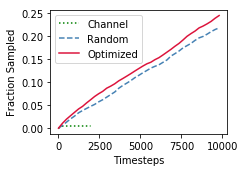

In [63]:
fig, ax = plt.subplots()

# Plot the data
ax.plot(sampling_rates['steps'][:len(sampling_rates['channel'])], sampling_rates['channel'], ':', label='Channel', color='green')
ax.plot(sampling_rates['steps'], sampling_rates['random'], '--', label='Random', color='steelblue')
ax.plot(sampling_rates['steps'], sampling_rates['single'], label='Optimized', color='crimson')

# Make it pretty
ax.legend()

ax.set_ylabel('Fraction Sampled')
ax.set_xlabel('Timesteps')

fig.set_size_inches(3.5, 2.5)
fig.tight_layout()
fig.savefig(os.path.join('figures', 'sampling-rate-figure.png'), dpi=320)